In [1]:
!pwd

/home/giakhang/dev/YOLOF-Mask/grad_cam


In [2]:
%cd ..

/home/giakhang/dev/YOLOF-Mask


In [3]:
import os
os.path.expanduser("~")

'/home/giakhang'

In [4]:
import sys

GRAD_CAM_DIR = os.path.join(os.path.expanduser('~'), 'dev/pytorch-grad-cam')
sys.path.append(GRAD_CAM_DIR)

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import glob
from typing import Dict, OrderedDict
from PIL import Image
import random

from pytorch_grad_cam import EigenCAM, AblationCAM, AblationLayer, GradCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image

from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer

In [6]:
def predict(input_tensor, model, detection_threshold):
    outputs = model.predict(input_tensor)
    pred_labels = outputs[0]['instances'].pred_classes.detach().cpu().numpy()
    pred_scores = outputs[0]['instances'].scores.detach().cpu().numpy()
    pred_bboxes = outputs[0]['instances'].pred_boxes.tensor.detach().cpu().numpy()
    pred_classes = [traffic_objects[i] for i in pred_labels]

    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color,
            2
        )
        cv2.putText(
            image,
            classes[i],
            (int(box[0]), int(box[1] - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            color,
            2,
            lineType=cv2.LINE_AA
        )
    return image

traffic_objects = ['car', 'bus', 'truck', 'train']   

# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(traffic_objects), 3))

In [7]:
pixel_mean = np.array([103.530, 116.280, 123.675])
pixel_std = np.array([57.375, 57.120, 58.395])

device = 'cuda'

In [8]:
image_path = 'datasets/bdd100k/images/10k/val/ff55861e-a06b953c.jpg'

raw_image = cv2.imread(image_path)
image_float_np = np.float32(raw_image) / 255
image_input = np.float32((raw_image - pixel_mean[None, None, :]) / pixel_std[None, None, :])
rgb_image = np.uint8(np.ascontiguousarray(raw_image[..., ::-1]))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image_input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

# Add a batch dimension
input_tensor = input_tensor.unsqueeze(0)

In [9]:
config_path = './configs/bdd100k/yolof_mask_RegNetX_4gf_SAM_3x.py'
weight_path = '/home/giakhang/Downloads/bdd_yolof_mask_regnetx_best.pth'

cfg = LazyConfig.load(config_path)

cfg.model.decoder.num_classes = len(traffic_objects)
cfg.model.mask_head.num_classes = len(traffic_objects)

model = instantiate(cfg.model)
model = model.to(device)
model.eval()
_ = DetectionCheckpointer(model).load(weight_path)

/home/giakhang/dev/albumentations/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


/home/giakhang/miniconda3/envs/rdpn6d/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


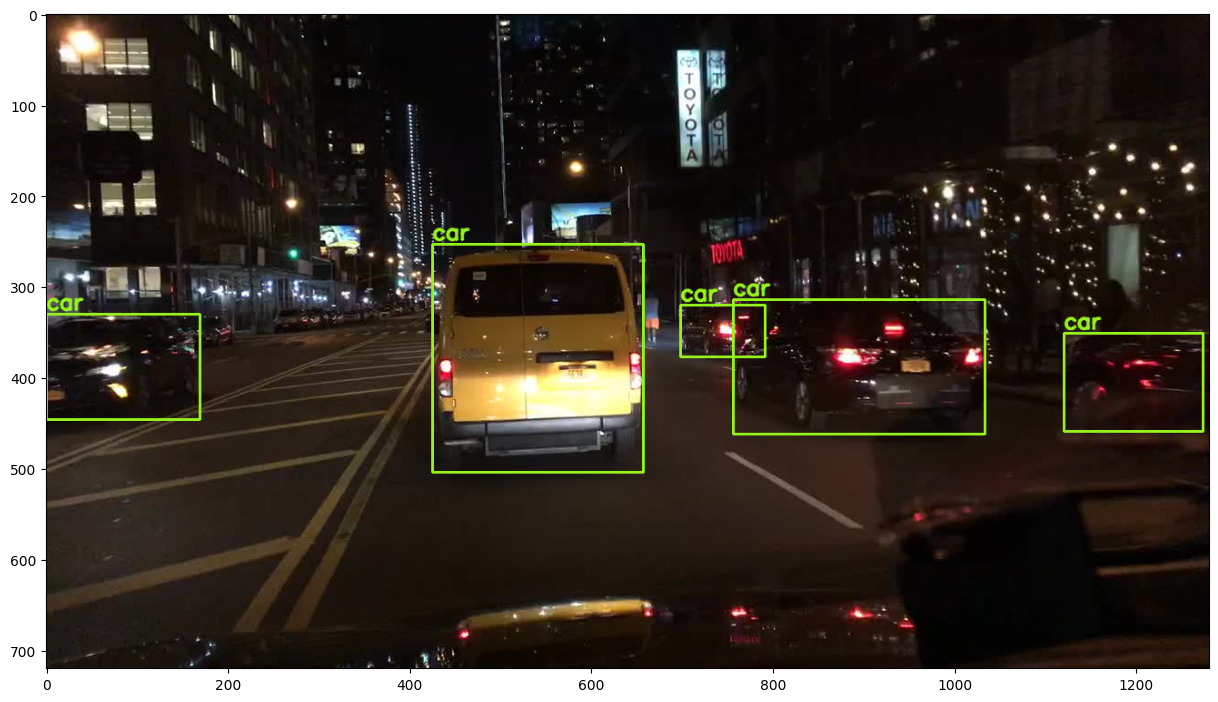

In [10]:
# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, 0.5)
drawed_image = draw_boxes(boxes, labels, classes, rgb_image)

_ = plt.figure(figsize=(15, 15))
plt.imshow(drawed_image)

In [11]:
class YOLOFMaskBoxScoreTarget:
    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0]).cuda()

        if len(model_outputs['instances'].pred_boxes.tensor) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :]).cuda()

            ious = torchvision.ops.box_iou(box, model_outputs['instances'].pred_boxes.tensor)
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs['instances'].pred_classes[index] == label:
                score = ious[0, index] + model_outputs['instances'].scores[index]
                output = output + score
        
        return output

In [12]:
def transform_backbone_output(x):
    if isinstance(x, Dict):
        return x['s4']
    return torch.relu(x)

def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        images.append(img)
    
    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes

In [13]:
class YOLOFMaskSegmentationBranch(torch.nn.Module):
    def __init__(self, model, instance_id=0):
        super(YOLOFMaskSegmentationBranch, self).__init__()
        self.model = model
        self.model.eval()
        self.instance_id = instance_id
    
    def predict(self, input_tensor):
        features = model.backbone(input_tensor)
        features = features[model.backbone._out_features[-1]]
        features_p5 = model.encoder(features)
        box_cls, box_delta = model.decoder(features_p5)
        anchors = model.anchor_generator([features_p5])
        proposals = model.inference([box_cls], [box_delta], anchors, [x.shape[-2:] for x in input_tensor])
        proposals = [p[self.instance_id] for p in proposals]
        proposal_boxes = [x.pred_boxes for x in proposals]
        box_features = model.pooler([features_p5], proposal_boxes)
        results = model.mask_head(box_features, proposals)
        return results

In [14]:
class SegmentationTarget:
    def __init__(self, mask):
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        pred_mask = model_output.pred_masks.squeeze()
        return (pred_mask * self.mask).sum()

In [15]:
num_images = 5
image_dir = '/home/giakhang/dev/YOLOF-Mask/datasets/bdd100k/images/10k/train'
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
choose_imgs = random.choices(image_paths, k=num_images)

instance_id = 0
yolof_mask_seg_model = YOLOFMaskSegmentationBranch(model, instance_id=instance_id)

target_layers = [
    model.backbone,
    model.encoder,
    model.decoder.cls_subnet,
    model.decoder.bbox_subnet,
    yolof_mask_seg_model.model.mask_head.mask_fcn6
]

target_names = [
    'backbone', 
    'encoder', 
    'cls_head', 
    'bbox_head', 
    'mask_head'
]

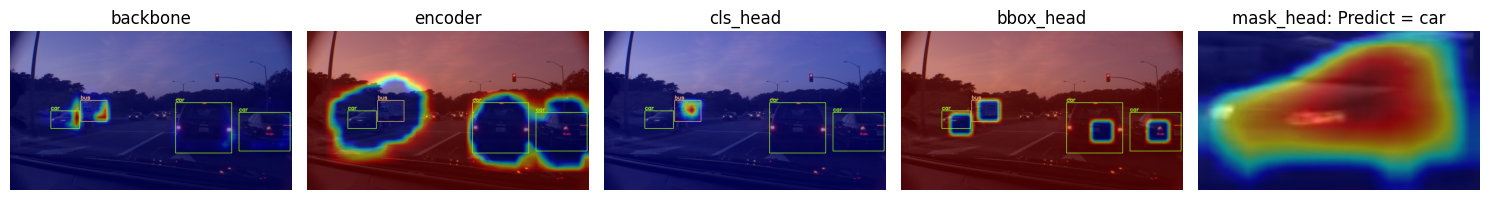

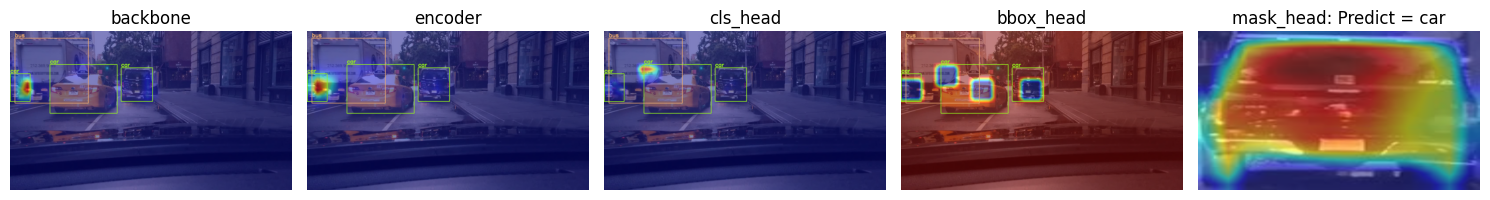

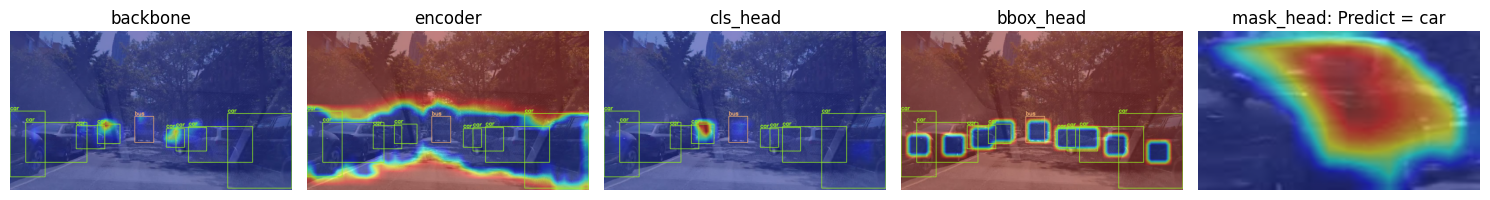

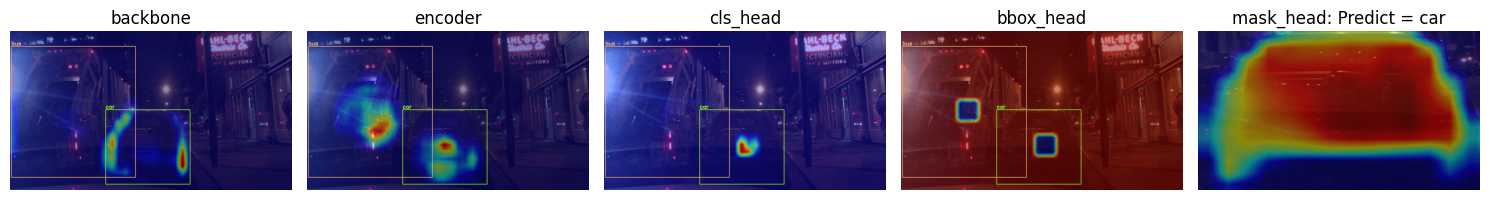

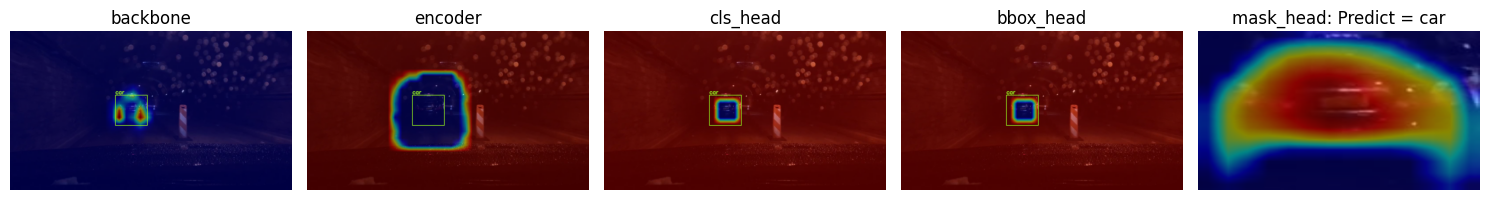

In [16]:
for img_path in choose_imgs:
    raw_image = cv2.imread(img_path)
    image_float_np = np.float32(raw_image) / 255.0
    image_input = np.float32((raw_image - pixel_mean[None, None, :]) / pixel_std[None, None, :])
    rgb_image = np.uint8(np.ascontiguousarray(raw_image[..., ::-1]))

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

    input_tensor = transform(image_input)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)

    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0)

    boxes, classes, labels, indices = predict(input_tensor, model, 0.5)
    if not len(boxes):
        continue

    instance_id = 0

    result = yolof_mask_seg_model.predict(input_tensor)
    cls_name = traffic_objects[result[0].pred_classes.detach().cpu().numpy()[0]]
    mask_float = np.float32(result[0].pred_masks.detach().squeeze().cpu().numpy() > 0.5)

    chossen_box = boxes[instance_id]
    crop_img = rgb_image[chossen_box[1]:chossen_box[3], chossen_box[0]:chossen_box[2], :]

    cam_imgs = []
    grayscale_cams = []
    pred_ins_classes = []

    for name, layer in zip(target_names, target_layers):
        if name != 'mask_head':
            targets = [YOLOFMaskBoxScoreTarget(labels=labels, bounding_boxes=boxes, iou_threshold=0.5)]
            cam = EigenGradCAM(
                model,
                target_layers=[layer],
                reshape_transform=transform_backbone_output,
            )
            grayscale_cam = cam(input_tensor, targets=targets)[0, :]
            cam_image = show_cam_on_image(image_float_np[..., ::-1], grayscale_cam, use_rgb=True)
            cam_image = draw_boxes(boxes, labels, classes, cam_image)
        else:
            targets = [SegmentationTarget(mask_float)]
            cam = GradCAM(model=yolof_mask_seg_model, target_layers=[layer])
            grayscale_cam = cam(input_tensor, targets=targets)[0, :]
            grayscale_cam = cv2.resize(grayscale_cam, (crop_img.shape[1], crop_img.shape[0]))
            cam_image = show_cam_on_image(crop_img / 255.0, grayscale_cam, use_rgb=True)
            cam_image = cv2.resize(cam_image, (cam_imgs[-1].shape[1], cam_imgs[-1].shape[0]))
            pred_ins_classes.append(cls_name)
        cam_imgs.append(cam_image)
        grayscale_cams.append(grayscale_cam)

    axs = plt.subplots(1, len(cam_imgs), figsize=(15, 15))

    for i, ax in enumerate(axs[1]):
        ax.imshow(cam_imgs[i])
        if (i + 1) % len(target_names) == 0:
            ax.set_title(f'{target_names[i]}: Predict = {pred_ins_classes[i // len(target_names)]}') 
        else:
            ax.set_title(target_names[i])
        ax.axis('off')

    plt.tight_layout()